In [1]:
import image_dataset_loader
from matplotlib import pyplot as plt
from sklearn import svm
import numpy as np
import mediapipe as mp
import cv2
from algebra_operators import eval_if_allowed, evaluate_expression
from time import time
from os import path
import pickle

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
if path.exists('new_train_data'):
    train_dataset, test_dataset = image_dataset_loader.create_datasets('new_train_data/data/')
    x_train, y_train = zip(*train_dataset)
    x_test, y_test = zip(*test_dataset)

    num_features = 126  # left/right hand, 21 landmarks, x/y/z positions
else:
    print('ignoring since new_train_data/data doesnt exist')

In [3]:
if path.exists('new_train_data'):
    print('processing data from existing folder')

    flattened_x_train_left = np.zeros((len(x_train), num_features))
    y_train_left = np.zeros((len(x_train), ), dtype=np.int8)

    for i in range(len(x_train)):
        flattened_x_train_left[i, :] = image_dataset_loader.process_image(x_train[i], y_train[i], True).flatten()
        y_train_left[i] = y_train[i]

    flattened_x_test_left = np.zeros((len(x_test), num_features))
    y_test_left = np.zeros((len(x_test), ), dtype=np.int8)

    for i in range(len(x_test)):
        flattened_x_test_left[i, :] = image_dataset_loader.process_image(x_test[i], y_test[i], True).flatten()
        y_test_left[i] = y_test[i]

    print('applying data augmentation to new dataset')

    flattened_x_train = np.zeros((len(x_train) * 2, num_features))
    y_train_both = np.zeros((len(x_train) * 2, ), dtype=np.int8)

    for i in range(len(x_train)):
        left_hand = image_dataset_loader.process_image(x_train[i], y_train[i], True)

        right_hand = np.copy(left_hand)
        right_hand[:, :, 0] = 1 - right_hand[:, :, 0]
        right_hand = np.flip(right_hand, axis=0)

        left_hand_flattened = left_hand.flatten()
        right_hand_flattened = right_hand.flatten()

        flattened_x_train[2 * i, :] = left_hand_flattened
        flattened_x_train[2 * i + 1, :] = right_hand_flattened

        y_train_both[2 * i] = y_train[i]
        y_train_both[2 * i + 1] = y_train[i]

    flattened_x_test = np.zeros((len(x_test) * 2, num_features))
    y_test_both = np.zeros((len(x_test) * 2, ), dtype=np.int8)

    for i in range(len(x_test)):
        left_hand = image_dataset_loader.process_image(x_test[i], y_test[i], True)

        right_hand = np.copy(left_hand)
        right_hand[:, :, 0] = 1 - right_hand[:, :, 0]
        right_hand = np.flip(right_hand, axis=0)

        left_hand_flattened = left_hand.flatten()
        right_hand_flattened = right_hand.flatten()

        flattened_x_test[2 * i, :] = left_hand_flattened
        flattened_x_test[2 * i + 1, :] = right_hand_flattened

        y_test_both[2 * i] = y_test[i]
        y_test_both[2 * i + 1] = y_test[i]
else:
    print('folder not found, ignoring')

processing data from existing folder
applying data augmentation to new dataset


In [4]:
if not path.exists('models/model_no_augmentv1.sav'):
    clf = svm.LinearSVC(dual="auto")
    clf.fit(flattened_x_train_left, y_train_left)
    pickle.dump(clf, open('models/model_no_augmentv1.sav', 'wb'))
else:
    print('found cached model v1')
    clf = pickle.load(open('models/model_no_augmentv1.sav', 'rb'))

if not path.exists('models/model_augmentv2.sav'):
    clf2 = svm.LinearSVC(dual="auto")
    clf2.fit(flattened_x_train, y_train_both)
    pickle.dump(clf2, open('models/model_augmentv2.sav', 'wb'))
else:
    print('found cached model v2')
    clf2 = pickle.load(open('models/model_augmentv2.sav', 'rb'))

found cached model v1
found cached model v2


In [5]:
if path.exists('new_train_data'):
    test_predictions = np.zeros((flattened_x_test_left.shape[0], 1))
    accuracy_test1, accuracy_test2, accuracy_test3 = 0, 0, 0

    test_predictions2 = np.zeros((flattened_x_test.shape[0], 1))
    test_predictions3 = np.zeros((flattened_x_test.shape[0], 1))

    for i in range(len(flattened_x_test_left)):
        landmark, label = flattened_x_test_left[i], y_test_left[i]

        # test 1
        dec1 = clf.decision_function(landmark.reshape(1, -1))
        test_predictions[i] = np.argmax(dec1,axis=1) == label

    for i in range(len(flattened_x_test)):
        landmark, label = flattened_x_test[i], y_test_both[i]

        # test 2
        dec2 = clf.decision_function(landmark.reshape(1, -1))
        test_predictions2[i] = np.argmax(dec2,axis=1) == label

        # test 3
        dec3 = clf2.decision_function(landmark.reshape(1, -1))
        test_predictions3[i] = np.argmax(dec3,axis=1) == label

    accuracy_test1 = np.sum(test_predictions) / test_predictions.shape[0]
    accuracy_test2 = np.sum(test_predictions2) / test_predictions2.shape[0]
    accuracy_test3 = np.sum(test_predictions3) / test_predictions3.shape[0]

    print('SVM ACCURACY TRAINED ON LEFT HAND, LEFT HAND TEST ' + str(accuracy_test1 * 100) + '%')
    print('SVM ACCURACY TRAINED ON LEFT HAND, RIGHT HAND TEST ' + str(accuracy_test2 * 100) + '%')
    print('SVM ACCURACY TRAINED ON LEFT & RIGHT HAND (AUGMENTATION), RIGHT HAND TEST ' + str(accuracy_test3 * 100) + '%')
else:
    print('new_train_data/data doesnt exist, so ignoring')

SVM ACCURACY TRAINED ON LEFT HAND, LEFT HAND TEST 100.0%
SVM ACCURACY TRAINED ON LEFT HAND, RIGHT HAND TEST 57.14285714285714%
SVM ACCURACY TRAINED ON LEFT & RIGHT HAND (AUGMENTATION), RIGHT HAND TEST 100.0%


61.9% accuracy for hand_world_landmarks

92.8% accuracy for hand_landmarks on 1 hand, restricted to 0-5

100% accuracy for hand_landmarks on 2 hands, restricted to 0-13 with full information on left/right hand and x/y/z

10


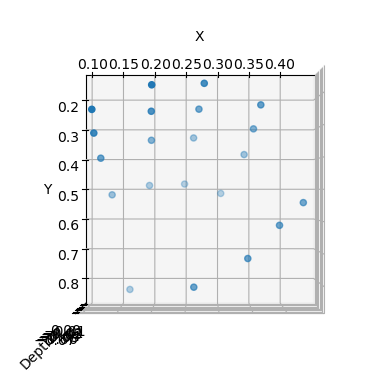

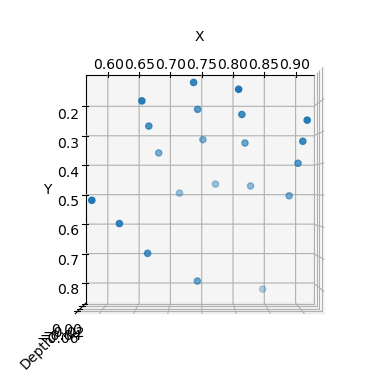

In [8]:
if path.exists('new_train_data'):
    for i in range(2,flattened_x_train_left.shape[0]):
        landmark = flattened_x_train_left[i]
        label = y_train_left[i]
        
        print(label)
        shaped = landmark.reshape(2, 21, 3)
        for i in range(shaped.shape[0]):
            x, y, z = zip(*shaped[i])

            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')

            ax.scatter(x, y, z)
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Depth')
            ax.view_init(elev=-90, azim=-90)
            plt.show()
        break
else:
    print('new_train_data/data doesnt exist, so ignoring')

yolov8 + CNN had too much variability

mediapipe + NN had subpar accuracy

mediapipe + SVM + x,y 1 hand landmarks had 92.8% accuracy

mediapipe + SVM + x,y,z 2 hand landmarks had 100% accuracy ON LEFT HAND and 52% on the RIGHT HAND

mediapipe + SVM + x,y,z 2 hand landmarks with augmented data has 100% on both left and right hand

In [7]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
mp_drawing = mp.solutions.drawing_utils

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("video stream unavailable")
    exit()

displayed_text = ''
displayed_count, last_displayed_text = 0, ''

display_result, start_time = '', 0

def add_to_displayed(res, last_displayed_text_arg, displayed_count_arg, displayed_text_arg):
    if res == last_displayed_text_arg:
        displayed_count_arg += 1
    else:
        displayed_count_arg = 0
    # last_displayed_text = res 
    if displayed_count_arg == 5:
        displayed_text_arg += res
    return res, displayed_count_arg, displayed_text_arg

def draw_rectangle(frame_to_use, text):
    height, width, _ = frame_to_use.shape
    rect_start_point = (50, height - 50)
    rect_end_point = (width - 50, height - 10)

    cv2.rectangle(frame_to_use, (50, height - 50), (width - 50, height - 10), (125,125,125), -1)

    font, font_size, font_color, font_thickness = cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2
    text_size = cv2.getTextSize(text, font, font_size, font_thickness)[0]
    text_x = rect_start_point[0] + (rect_end_point[0] - rect_start_point[0] - text_size[0]) // 2
    text_y = rect_start_point[1] + (rect_end_point[1] - rect_start_point[1] + text_size[1]) // 2
    cv2.putText(frame_to_use, text, (text_x, text_y), font, font_size, font_color, font_thickness, lineType=cv2.LINE_AA)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        continue

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    if display_result != '':
        if time() - start_time > 8:
            display_result = ''
            displayed_text = ''
            start_time = 0
        draw_rectangle(frame, 'Result: ' + str(display_result))
    else:
        results = hands.process(rgb_frame)

        if results is not None and results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            flattened = image_dataset_loader.process_image_prod(results.multi_hand_landmarks, results.multi_handedness)
            dec = clf2.decision_function(flattened.reshape(1, -1))
            res = str(np.argmax(dec,axis=1)[0])

            if res == '13':
                start_time = time()
                display_result = evaluate_expression(displayed_text) 
            else:
                if res == '11':
                    res = '+'
                elif res == '12':
                    res = 'x'

                if (res == '+' or res == 'x') and eval_if_allowed(displayed_text, res):
                    last_displayed_text, displayed_count, displayed_text = add_to_displayed(res, last_displayed_text, displayed_count, displayed_text)
                elif not (res == '+' or res == 'x'):
                    last_displayed_text, displayed_count, displayed_text = add_to_displayed(res, last_displayed_text, displayed_count, displayed_text)
            
            cv2.putText(frame, res, (10, 90), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 3, (0, 0, 255), 2)

        draw_rectangle(frame, displayed_text)

    cv2.imshow("Hand Tracking", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
